# <p align="center"> Hotel Allocation Project </p>
## <p align="right"> Alessandro Macchi 53633A </p> ##

### <p> Introduction </p> ###

In this project, the focus is on optimizing hotel room allocation strategies to balance revenue generation, room occupancy, and guest satisfaction. Using datasets containing hotel information, guest preferences, and room pricing, we developed several allocation strategies. These strategies include random assignment, prioritizing guest preferences, assigning based on cost, and allocating according to room availability. The goal was to analyze which strategy most effectively maximizes hotel occupancy rates, optimizes customer satisfaction, and generates the highest revenue, while considering specific factors like discount rates.

###Assumptions###

Before the beginning of the exposition, it is mandatory to make some assumptions about the project itself.
Firstly, we must notice that this is code has been created specifically for the datasets provided and ignores on purpose some conditions just because of the nature of the data.
The two main assumptions that have been done in this code is that (I) every hotel and guest has unique name, to be more specific they have codified names, and (II) it is sure that the guests have expressed preferences only about hotels that are in the datasets.
To check these conditions would be necessary some more code and controls that would have, uselessly, slow down the entire project, so that they have been excluded. However, being aware of these limitations is extremely important to understand the project.

###Moduls###

To create a more elegant environment, instead of add similar chunks of code we modularize the code, creating a separate and specific file (my_moduls) for the user-defined finctions that are repeatedly used in the code.

Before introducing the functions, we must rememeber to import the libraries.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The functions will be briefly presented in their main characteristics.

<font color="green">importing()</font> is used to import all the datasets.

In [7]:
def importing():
    # Import datasets
    ds_hotel = pd.read_csv("C:/Users/Utente/Desktop/dse/1t/python_project/Datasets/hotels.csv")
    ds_pref = pd.read_csv("C:/Users/Utente/Desktop/dse/1t/python_project/Datasets/preferences.csv")
    ds_guests = pd.read_csv("C:/Users/Utente/Desktop/dse/1t/python_project/Datasets/guests.csv")
    return ds_hotel, ds_pref, ds_guests

<font color="green">df_creation()</font> is one of the most complex one. 
This function creates three different dictionaries and converts them into dataframes with the pandas library.
For this project has been decided to add the preferences as a list of hotel, in order of preference, associated to every guest. This helps with some allocations, even though it may slow down the code.

In [8]:
def df_creation(ds_hotel, ds_pref, ds_guests):
    hotel = {
        'name': ds_hotel['hotel'],
        'price': ds_hotel['price'],
        'initial_rooms': pd.to_numeric(ds_hotel['rooms'], errors='coerce'),
        'final_rooms': pd.to_numeric(ds_hotel['rooms'], errors='coerce')
    }
    guests = {
        'name': ds_guests['guest'],
        'discount': pd.to_numeric(ds_guests['discount'], errors='coerce'),
        'preferences': ""
    }
    preferences = {
        'name': ds_pref['guest'],
        'hotel': ds_pref['hotel'],
        'number': ds_pref['priority']
    }
    
    # Create list of preferred hotels for each guest
    pref_list = []
    i = 0
    for guest in guests['name']:
        temporary_list = []
        while i < len(ds_pref) and ds_pref['guest'][i] == guest:
            temporary_list.append(ds_pref['hotel'][i])
            i += 1
        pref_list.append(temporary_list)
    
    hotel_df = pd.DataFrame(hotel)
    guests_df = pd.DataFrame(guests)
    priority_df = pd.DataFrame(preferences)
    
    guests_df['preferences'] = pref_list
    
    return hotel_df, guests_df, priority_df

<font color="green">hotel_wise_allocation()</font> has been created because two strategies (Price and Availability) have very similar needs, so the main part of the allocation can be standardized.

In [9]:
def hotel_wise_allocation(hotel_df, guests_df, assignment):
    for hotel_name, row in hotel_df.iterrows():
        # create a vector with the guests that have the hotel_name in their preferences
        guests_vector = guests_df[guests_df['preferences'].apply(lambda x: hotel_name in x)].index
        for guest_name in guests_vector:
            if row['final_rooms'] > 0 and guest_name not in assignment:
                assignment[guest_name] = hotel_name
                hotel_df.loc[hotel_name, 'final_rooms'] -= 1
            if hotel_df.loc[hotel_name, 'final_rooms'] <= 0:
                break
    return assignment

<font color="green">number_of_customers_accommodated()</font> counts the assigned guests.

In [10]:
def number_of_customers_accommodated(assignment):
    assigned_guests = len(assignment)
    return assigned_guests

<font color="green">number_of_rooms_occupied()</font> counts how many rooms have been occupied (equal to the number of the assigned guests). To do so it uses the numPy library.

In [11]:
def number_of_rooms_occupied(hotel_df):
    initial_rooms = hotel_df['initial_rooms'].to_numpy()
    final_rooms = hotel_df['final_rooms'].to_numpy()
    occupied_rooms = np.sum(initial_rooms - final_rooms)
    return occupied_rooms

<font color="green">number_of_different_hotels_occupied()</font> couts how many hotels are fully booked at the end of the allocation.

In [12]:
def number_of_different_hotels_occupied(hotel_df):
    full_hotels = 0
    for hotel in hotel_df.index:
        if hotel_df.loc[hotel, 'final_rooms'] == 0:
            full_hotels += 1
    return full_hotels

<font color="green">hotel_earnings()</font> is a function which creates a dictionary with the earnings for every hotel.

In [13]:
def hotel_earnings(assignment, guests_df, hotel_df):
    hotel_revenue = {}
    for guest, hotel in assignment.items():
        discount = guests_df.loc[guest, 'discount']
        price = hotel_df.loc[hotel, 'price']
        revenue = price * (1 - discount)
        hotel_revenue[hotel] = hotel_revenue.get(hotel, 0) + revenue

<font color="green">total_volume_of_business1()</font> defines the total revenue of the hotels, considering the discount associated to every guest.

In [14]:
def total_volume_of_business1(hotel_revenue):
    total_revenue = np.sum(hotel_revenue.values())
    return total_revenue

<font color="green">total_volume_of_business2()</font> is an alternative to <font color="green">total_volume_of_business1()</font> which uses numPy, but it is less efficient.

In [15]:
def total_volume_of_business2(assignment, guests_df, hotel_df):
    guests = np.array(list(assignment.keys()))
    hotels = np.array(list(assignment.values()))
    discounts = guests_df.loc[guests, 'discount'].values
    prices = hotel_df.loc[hotels, 'price'].values
    guest_prices = prices - (prices * discounts)
    total_revenue = np.sum(guest_prices)
    return total_revenue

<font color="green">customer_satisfaction_random()</font> is used to calculate the customer satisfaction in the random allocation, which is seprated because of special necesities (we must verify if the hotel is in the preference list). Even though it presents just once it has been stored here for tidyness motives.

In [16]:
def customer_satisfaction_random(guests_df, assignment_random):
    total_satisfaction_random = float(0)
    for guest in guests_df.index:
        preference_position = 0
        hotel_pref = guests_df.loc[guest, 'preferences']
        if assignment_random[guest] in hotel_pref:
            for i, preferred_hotel in enumerate(hotel_pref):
                if preferred_hotel == assignment_random[guest]:
                    preference_position = i
                    break
            g_satisfaction = (len(hotel_pref) - preference_position) / len(hotel_pref)
        else:
            g_satisfaction = 0
        total_satisfaction_random += g_satisfaction

    average_satisfaction_random = total_satisfaction_random / len(guests_df)
    return average_satisfaction_random

<font color="green">customer_satisfaction()</font> is used to calculate the customer satisfaction in every other strategy.

In [17]:
def customer_satisfaction(guests_df, assignment):
    total_satisfaction = float(0)
    for guest in guests_df.index:
        if guest in assignment.keys():
            preference_position = 0
            hotel_pref = guests_df.loc[guest, 'preferences']
            for i, preferred_hotel in enumerate(hotel_pref):
                if preferred_hotel == assignment[guest]:
                    preference_position = i
                    break
            g_satisfaction = (len(hotel_pref) - preference_position) / len(hotel_pref)
        else:
            g_satisfaction = 0
        total_satisfaction += g_satisfaction

    average_satisfaction = total_satisfaction / len(guests_df)
    return average_satisfaction

###Random allocation###

In [18]:
import random
import my_modules

ds_hotel, ds_pref, ds_guests = my_modules.importing()
hotel_df, guests_df, priority_df = my_modules.df_creation(ds_hotel, ds_pref, ds_guests)

hotel_df.set_index('name', inplace = True)
guests_df.set_index('name', inplace=True)
random.seed(6) # i want the same random result every time to analyze it
assignment_random = {}

for guest in guests_df.index:
    assigned_hotel = None
    while assigned_hotel is None:
        chosen_hotel = random.choice(hotel_df.index)
        row = hotel_df.loc[chosen_hotel]
        if row['final_rooms'] > 0:
            assignment_random[guest] = chosen_hotel
            hotel_df.loc[chosen_hotel, 'final_rooms'] -= 1
            assigned_hotel = chosen_hotel

assigned_guests_random = my_modules.number_of_customers_accommodated(assignment_random)

occupied_rooms_random = my_modules.number_of_rooms_occupied(hotel_df)

full_hotels_random = my_modules.number_of_different_hotels_occupied(hotel_df)

hotel_revenue_random = my_modules.hotel_earnings(assignment_random, guests_df, hotel_df)
total_revenue_random = my_modules.total_volume_of_business1(hotel_revenue_random)

# The random allocation has a specific function
average_satisfaction_random = my_modules.customer_satisfaction_random(guests_df, assignment_random)

We can start creating plots with the library MatPlotLib to confront results. Here we have the revenue for each hotel.

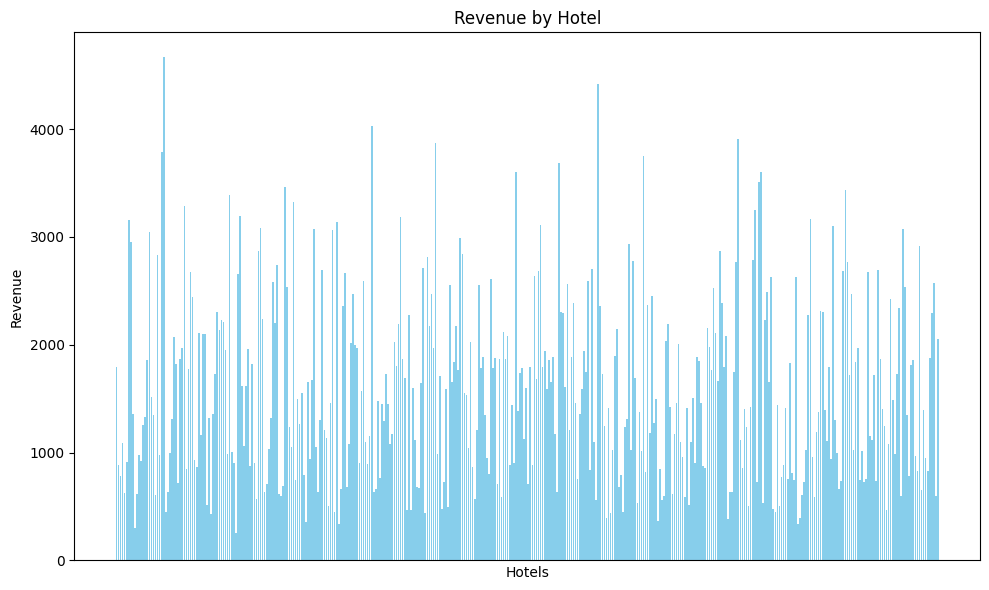

In [19]:
import my_graphs

rev_plot_random = my_graphs.plot_hotel_revenue(assignment_random, guests_df, hotel_df)

###Preferences allocation###

In [20]:
import my_modules

ds_hotel, ds_pref, ds_guests = my_modules.importing()
hotel_df, guests_df, priority_df = my_modules.df_creation(ds_hotel, ds_pref, ds_guests)

hotel_df.set_index('name', inplace = True)
guests_df.set_index('name', inplace = True)
assignment_preferences = {}

for guest in guests_df.index:
    preferences = guests_df.loc[guests_df.index == guest, 'preferences'].values[0]
    for chosen_hotel in preferences:
        row = hotel_df.loc[chosen_hotel]
        if row['final_rooms'] > 0:
            assignment_preferences[guest] = chosen_hotel
            hotel_df.loc[chosen_hotel, 'final_rooms'] -= 1
            break

assigned_guests_preferences = my_modules.number_of_customers_accommodated(assignment_preferences)

occupied_rooms_preferences = my_modules.number_of_rooms_occupied(hotel_df)

full_hotels_preferences = my_modules.number_of_different_hotels_occupied(hotel_df)

hotel_revenue_preferences = my_modules.hotel_earnings(assignment_preferences, guests_df, hotel_df)
total_revenue_preferences = my_modules.total_volume_of_business1(hotel_revenue_preferences)

average_satisfaction_preferences = my_modules.customer_satisfaction(guests_df, assignment_preferences)

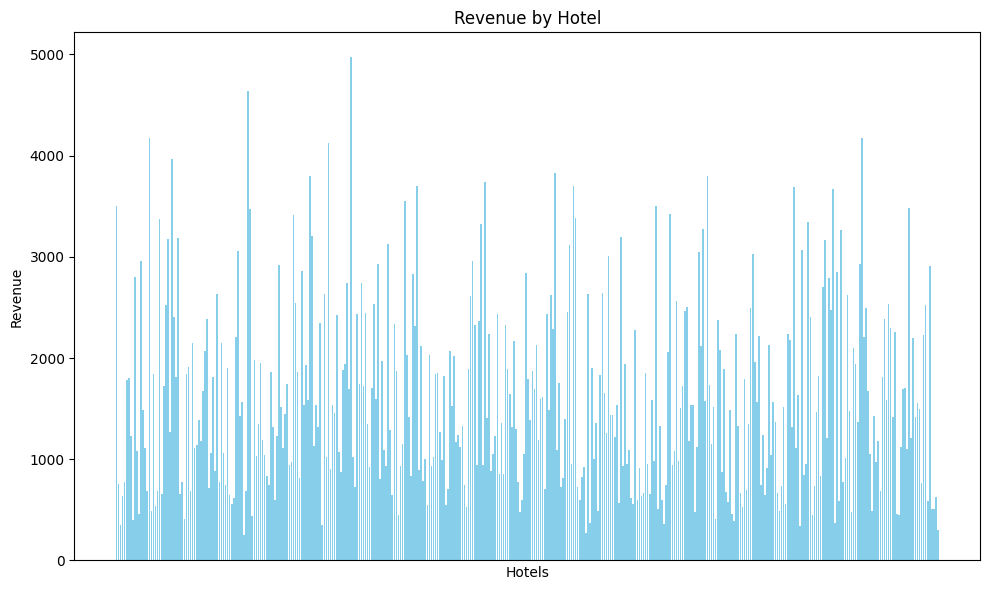

In [21]:
import my_graphs

rev_plot_preferences = my_graphs.plot_hotel_revenue(assignment_preferences, guests_df, hotel_df)

###Price allocation###

In [22]:
import my_modules

ds_hotel, ds_pref, ds_guests = my_modules.importing()
hotel_df, guests_df, priority_df = my_modules.df_creation(ds_hotel, ds_pref, ds_guests)

hotel_df.sort_values(by = 'price', ascending = True, inplace = True)
hotel_df.set_index('name', inplace = True)
guests_df.set_index('name', inplace = True)

assignment_price = {}
assignment_price = my_modules.hotel_wise_allocation(hotel_df, guests_df, assignment_price)

assigned_guests_price = my_modules.number_of_customers_accommodated(assignment_price)

occupied_rooms_price = my_modules.number_of_rooms_occupied(hotel_df)

full_hotels_price = my_modules.number_of_different_hotels_occupied(hotel_df)

hotel_revenue_price = my_modules.hotel_earnings(assignment_price, guests_df, hotel_df)
total_revenue_price = my_modules.total_volume_of_business1(hotel_revenue_price)

average_satisfaction_price = my_modules.customer_satisfaction(guests_df, assignment_price)

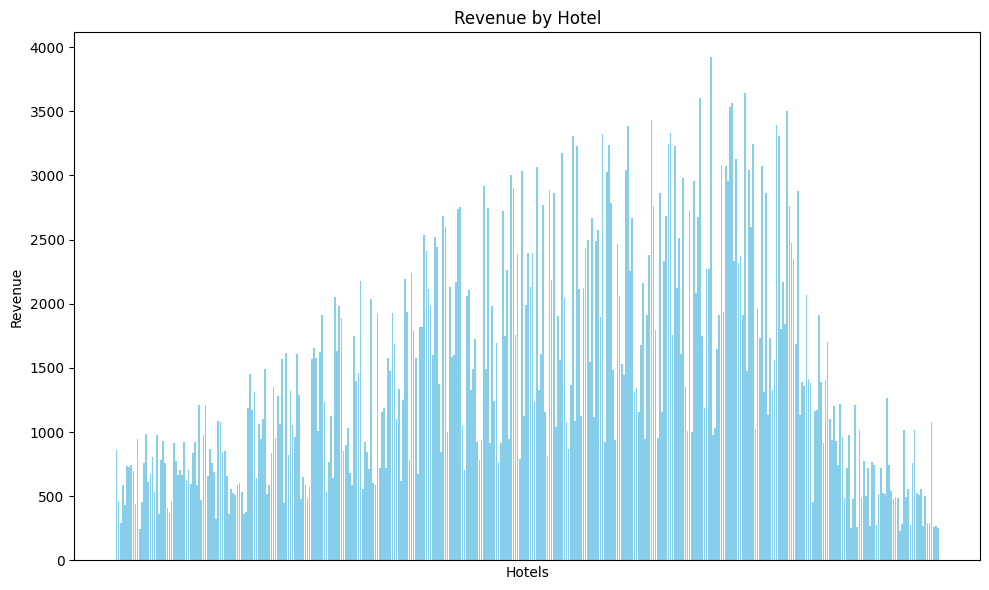

In [23]:
import my_graphs

rev_plot_price = my_graphs.plot_hotel_revenue(assignment_price, guests_df, hotel_df)

###Availability allocation###

In [24]:
import my_modules

ds_hotel, ds_pref, ds_guests = my_modules.importing()
hotel_df, guests_df, priority_df = my_modules.df_creation(ds_hotel, ds_pref, ds_guests)

hotel_df.sort_values(by = 'initial_rooms', ascending = False, inplace = True)
hotel_df.set_index('name', inplace = True)
guests_df.set_index('name', inplace = True)

assignment_availability = {}
assignment_availability = my_modules.hotel_wise_allocation(hotel_df, guests_df, assignment_availability)

assigned_guests_availability = my_modules.number_of_customers_accommodated(assignment_availability)

occupied_rooms_availability = my_modules.number_of_rooms_occupied(hotel_df)

full_hotels_availability = my_modules.number_of_different_hotels_occupied(hotel_df)

hotel_revenue_availability = my_modules.hotel_earnings(assignment_availability, guests_df, hotel_df)
total_revenue_availability = my_modules.total_volume_of_business1(hotel_revenue_availability)

average_satisfaction_availability = my_modules.customer_satisfaction(guests_df, assignment_availability)

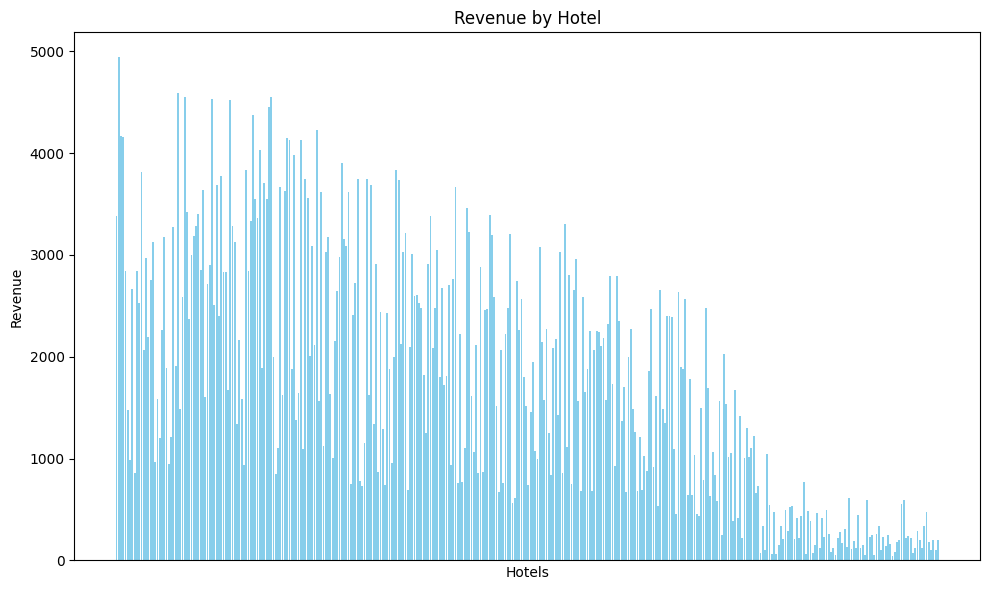

In [25]:
import my_graphs

rev_plot_availability = my_graphs.plot_hotel_revenue(assignment_availability, guests_df, hotel_df)

###Final report###

In [26]:
from tabulate import tabulate

allocation_results = [
    ["Random Strategy", assigned_guests_random, occupied_rooms_random, full_hotels_random, total_revenue_random, average_satisfaction_random],
    ["Preference Strategy", assigned_guests_preferences, occupied_rooms_preferences, full_hotels_preferences, total_revenue_preferences, average_satisfaction_preferences],
    ["Price Strategy", assigned_guests_price, occupied_rooms_price, full_hotels_price, total_revenue_price, average_satisfaction_price],
    ["Availability Strategy", assigned_guests_availability, occupied_rooms_availability, full_hotels_availability, total_revenue_availability, average_satisfaction_availability],
]

headers = ["Allocation Strategy", "Assigned Guests", "Occupied Rooms", "Hotels Fully Occupied", "Total Revenue", "Avg. Satisfaction"]
print(tabulate(allocation_results, headers=headers, tablefmt="grid"))

+-----------------------+-------------------+------------------+-------------------------+-----------------+---------------------+
| Allocation Strategy   |   Assigned Guests |   Occupied Rooms |   Hotels Fully Occupied |   Total Revenue |   Avg. Satisfaction |
+=======================+===================+==================+=========================+=================+=====================+
| Random Strategy       |              4000 |             4000 |                     246 |          637009 |           0.0329926 |
+-----------------------+-------------------+------------------+-------------------------+-----------------+---------------------+
| Preference Strategy   |              3975 |             3975 |                     255 |          643598 |           0.975309  |
+-----------------------+-------------------+------------------+-------------------------+-----------------+---------------------+
| Price Strategy        |              3926 |             3926 |                   

Using MatPlotLib it is possible to create some graph to analyze the results.

As we can see in the following bar plot, the final revenues for each strategy is similar for every strategy, except for the price allocation. Intuitevely this seems correct, because this strategy's first condition is to occupied the cheaper hotels, bringingless revenues.

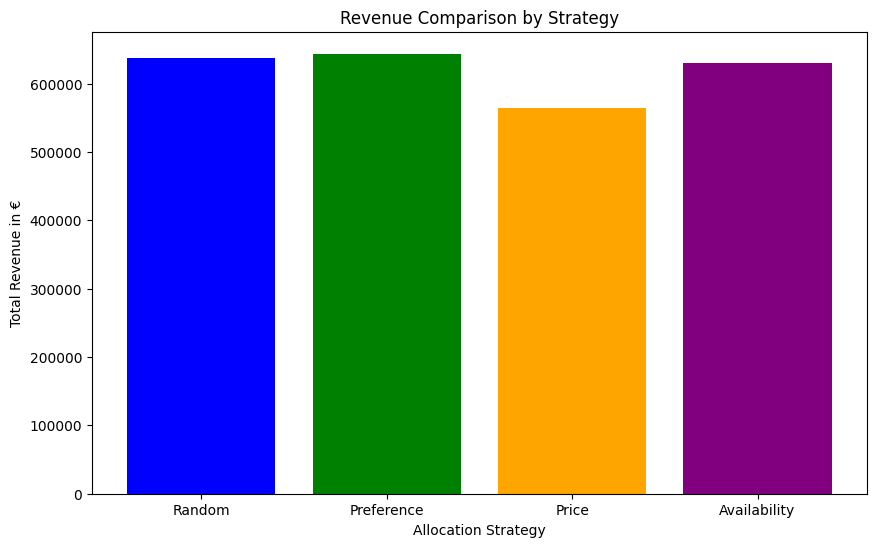

In [27]:
import my_graphs

my_graphs.revenue_comparison_by_strategy(total_revenue_random, total_revenue_preferences, total_revenue_price, total_revenue_availability)

In the second plot we analyze the customer satisfaction. In an analogue way as the previous plot, here the result seems logically correct: when the guests preferences are inputed as the main condition, then the customer satisfaction is almost at 100%.
We can also notice that when the preferences are inputed as a secondary condition, then the customer are happy only around the 50% of the time, both in price allocation and in availability allocation.
In conclusion, the random strategy is the worst one in this way: a guest can be assigned to an hotel which is not in his preferences list.

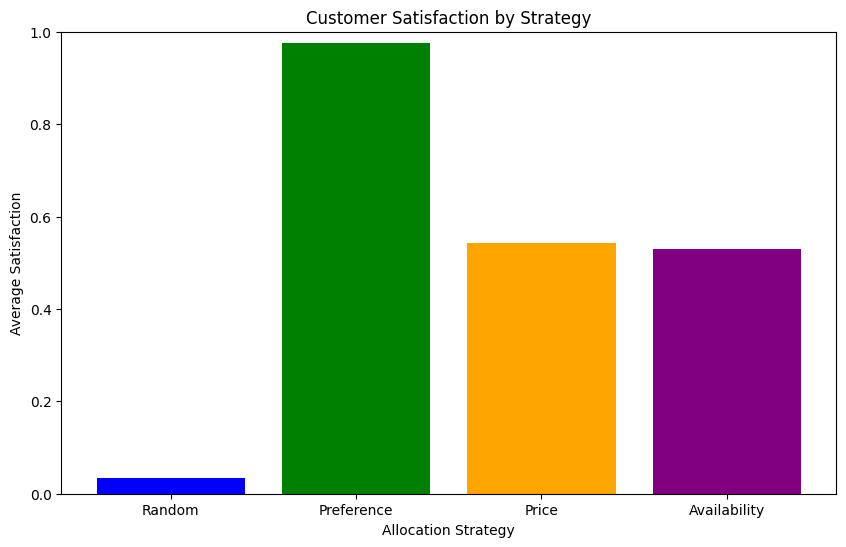

In [28]:
import my_graphs

my_graphs.customer_satisfaction_by_strategy(average_satisfaction_random, average_satisfaction_preferences, average_satisfaction_price, average_satisfaction_availability)

###Conclusion###



Through the analysis of various allocation strategies, we gained insights into the effectiveness of different approaches in maximizing both revenue and customer satisfaction. The strategies demonstrated that a preference-based approach could enhance guest satisfaction, while cost-based allocation helped optimize revenue generation, even if not very much.